<a href="https://colab.research.google.com/github/ArslanAmanov/AI-ML-DL/blob/default-branch/ML_models%20research%20notebooks/LGBM_research%20%26%20review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LGBM Model Research

LightGBM( Light Gradient Boosting Machine) is a popular gradient boosting framework for machine learning tasks, especially in the field of tabular data.
It was developed by Microsoft and is known for its efficiency, speed and ability to handle large datasets.



# Gradient Boosting overview:

Gradient boosting is an ensemble learning technique used for both classification and regression tasks. It builds of decision trees sequentially, where each tree corrects the errors made by the previous one.

# Step by Step process of gradient boosting:

1. Start with an initial prediction(usually the mean of the target values for regression or a balanced class distribution for classification).
2. Calculate the residuals (the difference between the actual and predicted values) for each data point.
3. Fit a decision tree to the residuals. This tree is often referred to as a "weak learner" because it's simple model.
4. Add the predictions from the new tree to the previous predictions, which updates the model's predictions.
5. Repeat steps 2-4 for a special number of iterations or until a predefined stopping criterion is met.
6. The final ensemble model is the sum of all the predictions from the individual trees.

# LGBM Features:
LightGBM offers several features and optimizations that make it stand out:

1. Gradient Boosting with Histogram-Based Learning: LGBM uses histogram based learning which bins the continuous feature values into discrete bins. This speeds up the training process and reduces memory usage compared to traditional tree-based models.
2. Leaf Wise Growth: LGBM uses a leaf-wise tree growth strategy rather than a level-wise strategy, which can lead to more accurate models with fewer leaves. This reduces overfitting.
3. Gradient-Based One-Side Sampling(GOOS): GOOS is a technique used to subsample the data points during training. It keeps the data points with large gradients(which contribute more to the model) while randomly sampling those with small gradient. This improves both training speed and generalization.
4. Exclusive Feature Bundling: LGBM supports feature bundling, which groups related features together. This reduces the dimensionality of the data and can improve model performance.
5. Regularization: LGBM provides options for L1 and L2 regularization to prevent overfitting.
6. Categorical Feature Support: LGBM can handle categorical features directly without one-hot encoding, making it more memory-efficient.
7. Parallel and GPU Learning: LGBM is highly optimized for parallel processing and can leverage GPU's for even faster  training.
8. Early Stopping: You can use early stopping to halt training when the model's performance on a validation dataset plateaus or worsens, preventing overfitting.


# Install

The preferred way to install LightGBM is via pip:

In [ ]:
! pip install lightgbm

In [ ]:
# verify your installation, try to
import lightgbm as lgb

# Data Interface
The LightGBM Python module can load data from:

LibSVM (zero-based) / TSV / CSV format text file

NumPy 2D array(s), pandas DataFrame, H2O DataTable’s Frame, SciPy sparse matrix

LightGBM binary file

LightGBM Sequence object(s)

The data is stored in a Dataset object.


Many of the examples in this page use functionality from numpy. To run the examples, be sure to import numpy in your session.

In [ ]:
import numpy as np

To load a LibSVM(zero-based) text file or a LGBM binary file into Dataset:

In [ ]:
train_data = lgb.Dataset('train.svm.bin')

# To load a numpy array into Dataset:

In [ ]:
data = np.random.rand(500, 10)  # 500 entities, each contains 10 features
label = np.random.randint(2, size=500)  # binary target
train_data = lgb.Dataset(data, label=label)

# To load a scipy.sparse.csr_matrix array into Dataset:

In [ ]:
# import scipy
# csr = scipy.sparse.csr_matrix((data, (row, col)))
# train_data = lgb.Dataset(csr)

# Load from Sequence objects:

We can implement Sequence interface to read binary files. The following example shows reading HDF5 file with h5py.

In [ ]:
import h5py

class HDFSequence(lgb.Sequence):
    def __init__(self, hdf_dataset, batch_size):
        self.data = hdf_dataset
        self.batch_size = batch_size

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)

f = h5py.File('train.hdf5', 'r')
train_data = lgb.Dataset(HDFSequence(f['X'], 8192), label=f['Y'][:])

# Saving Dataset into a LightGBM binary file will make loading faster:

In [ ]:
train_data = lgb.Dataset('train.svm.txt')
train_data.save_binary('train.bin')

# Create validation data:

In [ ]:
validation_data = train_data.create_valid('validation.svm')

In [ ]:
# or
validation_data = lgb.Dataset('validation.svm', reference=train_data)
#In LightGBM, the validation data should be aligned with training data.

# Specific feature names and categorical features:

In [ ]:
train_data=lgb.Dataset(data, label=label, feature_name=['c1', 'c2','c3'], categorical_feature=['c3'])

LightGBM can use categorical features as input directly. It doesn’t need to convert to one-hot encoding, and is much faster than one-hot encoding (about 8x speed-up).

Note: You should convert your categorical features to int type before you construct Dataset.

# Weights can be set when needed:

In [ ]:
w = np.random.rand(500, )
train_data = lgb.Dataset(data, label=label, weight=w)

In [ ]:
# or
train_data = lgb.Dataset(data, label=label)
w = np.random.rand(500, )
train_data.set_weight(w)

# Setting parameters

Booster parameters:

In [ ]:
param = {'num_leaves': 31, 'objective': 'binary'}
param['metric'] = 'auc'

In [ ]:
# You can also specify multiple eval metrics:
param['metric']=['auc', 'binary_logloss']

# Training
Training a model requires a parameter list and data set:

In [ ]:
num_round = 10
bst = lgb.train(param, train_data, num_round, valid_sets=[validation_data])

After training, the model can be saved:

In [ ]:
bst.save_model('model.txt')

The trained model can also be dumped to JSON format:

In [ ]:
json_model = bst.dump_model()

A saved model can be loaded:

In [ ]:
bst = lgb.Booster(model_file='model.txt')  # init model

# Early Stopping
If you have a validation set, you can use early stopping to find the optimal number of boosting rounds. Early stopping requires at least one set in valid_sets. If there is more than one, it will use all of them except the training data:

In [ ]:
bst = lgb.train(param, train_data, num_round, valid_sets=valid_sets, callbacks=[lgb.early_stopping(stopping_rounds=5)])
bst.save_model('model.txt', num_iteration=bst.best_iteration)

The model will train until the validation score stops improving. Validation score needs to improve at least every stopping_rounds to continue training.

The index of iteration that has the best performance will be saved in the best_iteration field if early stopping logic is enabled by setting early_stopping callback. Note that train() will return a model from the best iteration.

This works with both metrics to minimize (L2, log loss, etc.) and to maximize (NDCG, AUC, etc.). Note that if you specify more than one evaluation metric, all of them will be used for early stopping. However, you can change this behavior and make LightGBM check only the first metric for early stopping by passing first_metric_only=True in early_stopping callback constructor.

In [ ]:
#If early stopping is enabled during training, you can get predictions from the best iteration with bst.best_iteration:
ypred = bst.predict(data, num_iteration=bst.best_iteration)

# Optimization in Speed and Memory Usage
Many boosting tools use pre-sort-based algorithms  (e.g. default algorithm in
xgboost) for decision tree learning. It is a simple solution, but not easy to optimize.

**Reduced cost of calculating the gain for each split**



*  Pre-sort-based algorithms have time complexity O(#data)
*  Computing the histogram has time complexity O(#data), but this involves only a fast sum-up operation. Once the histogram is constructed, a histogram-based algorithm has time complexity O(#bins), and #bins is far smaller than #data.


**Use histogram subtraction for further speedup**

* To get one leaf’s histograms in a binary tree, use the histogram subtraction of its parent and its neighbor

* So it needs to construct histograms for only one leaf (with smaller #data than its neighbor). It then can get histograms of its neighbor by histogram subtraction with small cost (O(#bins))

**Reduce memory usage**

* Replaces continuous values with discrete bins. If #bins is small, can use small data type, e.g. uint8_t, to store training data
* No need to store additional information for pre-sorting feature values

**Reduce communication cost for distributed learning**

# Sparse Optimization
Need only O(2 * #non_zero_data) to construct histogram for sparse features

# Optimization in Accuracy
# Leaf-wise (Best-first) Tree Growth
Most decision tree learning algorithms grow trees by level (depth)-wise, like the following image:
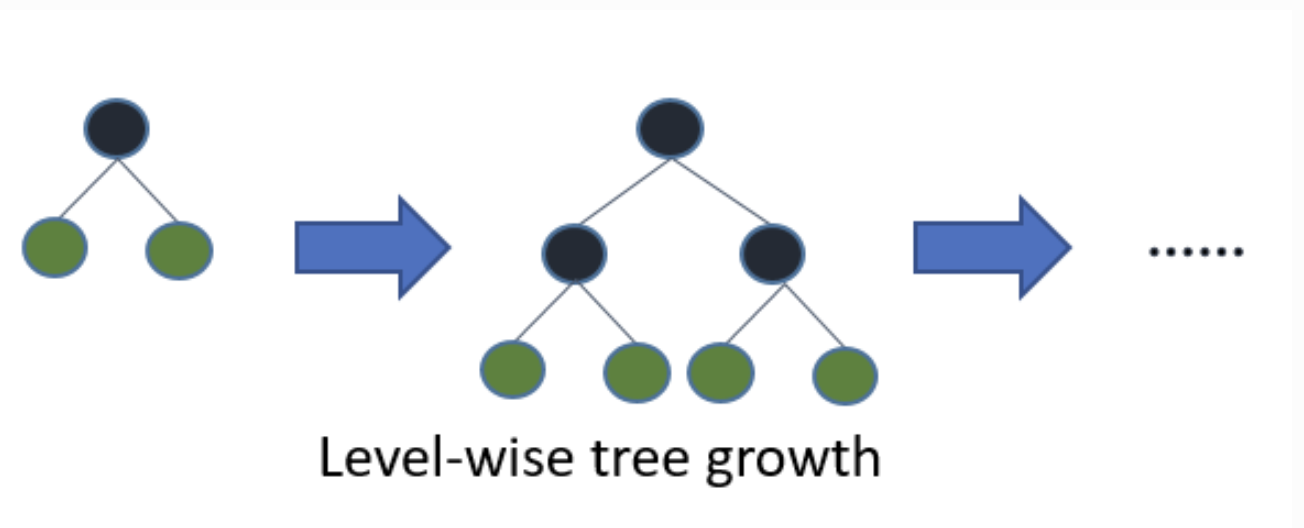

* LightGBM grows trees leaf-wise (best-first). It will choose the leaf with max delta loss to grow. Holding #leaf fixed, leaf-wise algorithms tend to achieve lower loss than level-wise algorithms.

* Leaf-wise may cause over-fitting when #data is small, so LightGBM includes the max_depth parameter to limit tree depth. However, trees still grow leaf-wise even when max_depth is specified.
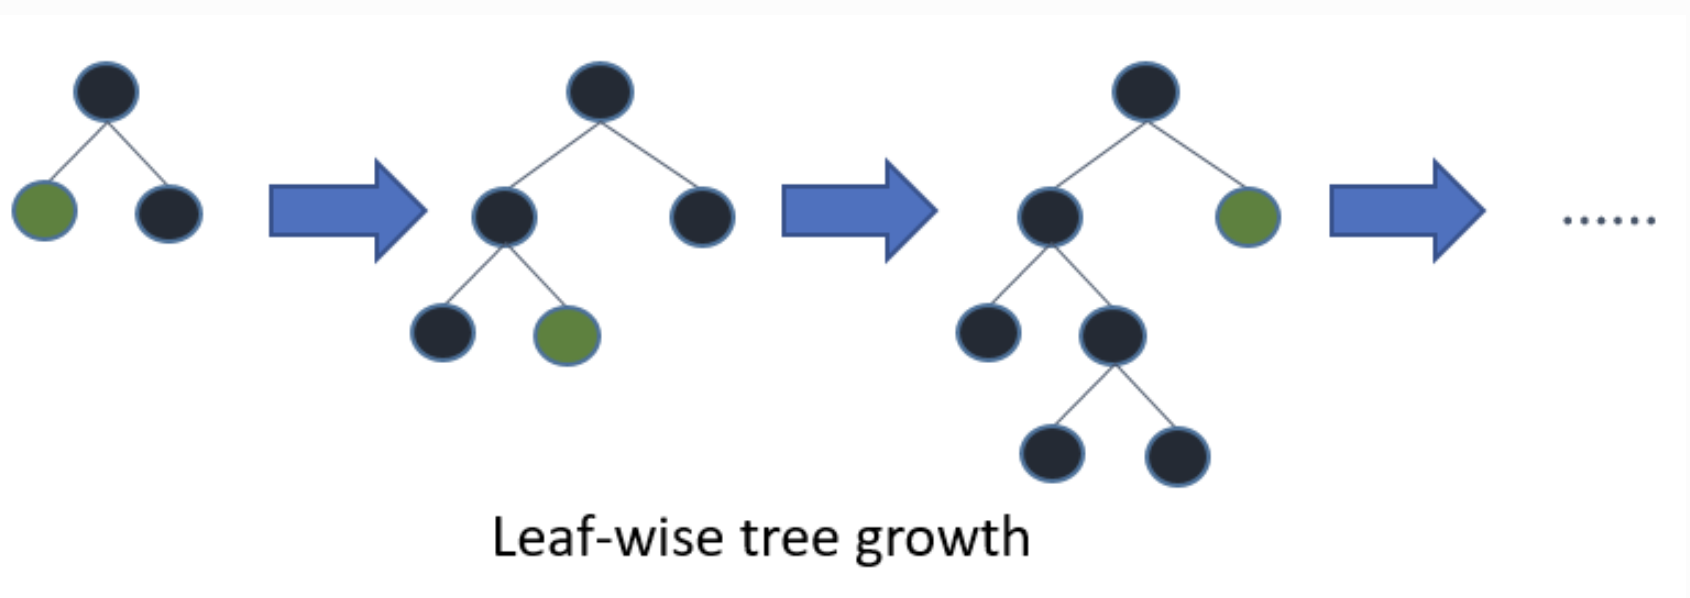

# Optimal Split for Categorical Features
* It is common to represent categorical features with one-hot encoding, but this approach is suboptimal for tree learners. Particularly for high-cardinality categorical features, a tree built on one-hot features tends to be unbalanced and needs to grow very deep to achieve good accuracy.


* Instead of one-hot encoding, the optimal solution is to split on a categorical feature by partitioning its categories into 2 subsets. If the feature has k categories, there are 2^(k-1) - 1 possible partitions. But there is an efficient solution for regression trees.It needs about O(k * log(k)) to find the optimal partition.


* The basic idea is to sort the categories according to the training objective at each split. More specifically, LightGBM sorts the histogram (for a categorical feature) according to its accumulated values (sum_gradient / sum_hessian) and then finds the best split on the sorted histogram.

# Tune Parameters for the Leaf-wise (Best-first) Tree

LightGBM uses the leaf-wise tree growth algorithm, while many other popular tools use depth-wise tree growth. Compared with depth-wise growth, the leaf-wise algorithm can converge much faster. However, the leaf-wise growth may be over-fitting if not used with the appropriate parameters.

To get good results using a leaf-wise tree, these are some important parameters:

* num_leaves. This is the main parameter to control the complexity of the tree model. Theoretically, we can set num_leaves = 2^(max_depth) to obtain the same number of leaves as depth-wise tree. However, this simple conversion is not good in practice. The reason is that a leaf-wise tree is typically much deeper than a depth-wise tree for a fixed number of leaves. Unconstrained depth can induce over-fitting. Thus, when trying to tune the num_leaves, we should let it be smaller than 2^(max_depth). For example, when the max_depth=7 the depth-wise tree can get good accuracy, but setting num_leaves to 127 may cause over-fitting, and setting it to 70 or 80 may get better accuracy than depth-wise.

* min_data_in_leaf. This is a very important parameter to prevent over-fitting in a leaf-wise tree. Its optimal value depends on the number of training samples and num_leaves. Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting. In practice, setting it to hundreds or thousands is enough for a large dataset.

* max_depth. You also can use max_depth to limit the tree depth explicitly.

# Grow Shallower Tree

The total training time for LightGBM increases with the total number of tree nodes added. LightGBM comes with several parameters that can be used to control the number of nodes per tree.

**The suggestions below will speed up training, but might hurt training accuracy.**


**Decrease max_depth**
* This parameter is an integer that controls the maximum distance between the root node of each tree and a leaf node. Decrease **max_depth** to reduce training time.

**Decrease num_leaves**
* LightGBM adds nodes to trees based on the gain from adding that node, regardless of depth. This figure from the feature documentation illustrates the process.

* Because of this growth strategy, it isn’t straightforward to use **max_depth** alone to limit the complexity of trees. The **num_leaves** parameter sets the maximum number of nodes per tree. Decrease **num_leaves** to reduce training time.


**Increase min_gain_to_split**
* When adding a new tree node, LightGBM chooses the split point that has the largest gain. Gain is basically the reduction in training loss that results from adding a split point. By default, LightGBM sets **min_gain_to_split** to 0.0, which means “there is no improvement that is too small”. However, in practice you might find that very small improvements in the training loss don’t have a meaningful impact on the generalization error of the model. Increase **min_gain_to_split** to reduce training time.

**Increase min_data_in_leaf and min_sum_hessian_in_leaf**
* Depending on the size of the training data and the distribution of features, it’s possible for LightGBM to add tree nodes that only describe a small number of observations. In the most extreme case, consider the addition of a tree node that only a single observation from the training data falls into. This is very unlikely to generalize well, and probably is a sign of overfitting.


This can be prevented indirectly with parameters like **max_depth** and **num_leaves**, but LightGBM also offers parameters to help you directly avoid adding these overly-specific tree nodes.

* **min_data_in_leaf**: Minimum number of observations that must fall into a tree node for it to be added.

* **min_sum_hessian_in_leaf**: Minimum sum of the Hessian (second derivative of the objective function evaluated for each observation) for observations in a leaf. For some regression objectives, this is just the minimum number of records that have to fall into each node.
* For classification objectives, it represents a sum over a distribution of probabilities. See this Stack Overflow answer for a good description of how to reason about values of this parameter.

# Save Constructed Datasets with **save_binary**
This only applies to the LightGBM CLI. If you pass parameter **save_binary**, the training dataset and all validations sets will be saved in a binary format understood by LightGBM. This can speed up training next time, because binning and other work done when constructing a Dataset does not have to be re-done.

# For Better Accuracy
* Use large **max_bin** (may be slower)

* Use small **learning_rate** with large num_iterations

* Use large** num_leaves** (may cause over-fitting)

* Use bigger training data

* Try dart

# Deal with Over-fitting
* Use small **max_bin**

* Use small **num_leaves**

* Use **min_data_in_leaf** and **min_sum_hessian_in_leaf**

* Use bagging by set **bagging_fraction** and **bagging_freq**

* Use feature **sub-sampling** by set **feature_fraction**

* Use bigger training data

* Try **lambda_l1**, **lambda_l2** and **min_gain_to_split** for regularization

* Try **max_depth** to avoid growing deep tree

* Try **extra_trees**

* Try increasing **path_smooth**